In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import matplotlib.colors as colors


from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,precision_score,recall_score,f1_score,recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC


In [ ]:
import importlib
import ast

In [ ]:
data_raw = pd.read_csv('https://drive.google.com/uc?export=download&id=1xtwMAFoVFV2FCAahPrCswBljut09eK1i')
data_raw.head(3)
#Explain code data_raw = pd.read_csv('https://drive.google.com/uc?export=download&id= + 1xtwMAFoVFV2FCAahPrCswBljut09eK1i <- trong link drive
#Source https://www.kaggle.com/datasets/ninopadilla13/employee-churn/data
#Origin Source https://elitedatascience.com/

,avg_monthly_hrs,department,filed_complaint,last_evaluation,n_projects,recently_promoted,salary,satisfaction,status,tenure
0,221,engineering,NaN,0.932868,4,NaN,low,0.829896,Left,5.0
1,232,support,NaN,NaN,3,NaN,low,0.834544,Employed,2.0
2,184,sales,NaN,0.788830,3,NaN,medium,0.834988,Employed,3.0


In [ ]:
data_raw.status.value_counts()

Employed    10857
Left         3392
Name: status, dtype: int64

In [ ]:
data_raw.info()
# 1 Department fill mode
# 2 filled_complaint fill 0
# 3 last_evaluation fill by mean department or mean if there are no different
# 5 recently_promoted delete because of too much missing data
# 7,9 satisfaction and tenure fill by department average


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14249 entries, 0 to 14248
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   avg_monthly_hrs    14249 non-null  int64  
 1   department         13540 non-null  object 
 2   filed_complaint    2058 non-null   float64
 3   last_evaluation    12717 non-null  float64
 4   n_projects         14249 non-null  int64  
 5   recently_promoted  300 non-null    float64
 6   salary             14249 non-null  object 
 7   satisfaction       14068 non-null  float64
 8   status             14249 non-null  object 
 9   tenure             14068 non-null  float64
dtypes: float64(5), int64(2), object(3)
memory usage: 1.1+ MB


In [ ]:
data_raw.describe()

,avg_monthly_hrs,filed_complaint,last_evaluation,n_projects,recently_promoted,satisfaction,tenure
count,14249.000000,2058.0,12717.000000,14249.000000,300.0,14068.000000,14068.000000
mean,199.795775,1.0,0.718477,3.773809,1.0,0.621295,3.497228
std,50.998714,0.0,0.173062,1.253126,0.0,0.250469,1.460917
min,49.000000,1.0,0.316175,1.000000,1.0,0.040058,2.000000
25%,155.000000,1.0,0.563866,3.000000,1.0,0.450390,3.000000
50%,199.000000,1.0,0.724939,4.000000,1.0,0.652527,3.000000
75%,245.000000,1.0,0.871358,5.000000,1.0,0.824951,4.000000
max,310.000000,1.0,1.000000,7.000000,1.0,1.000000,10.000000


# **EDA**

In [ ]:
#Create a copy to EDA
eda=data_raw.copy()

Text(0.5, 1.0, 'n_projects')

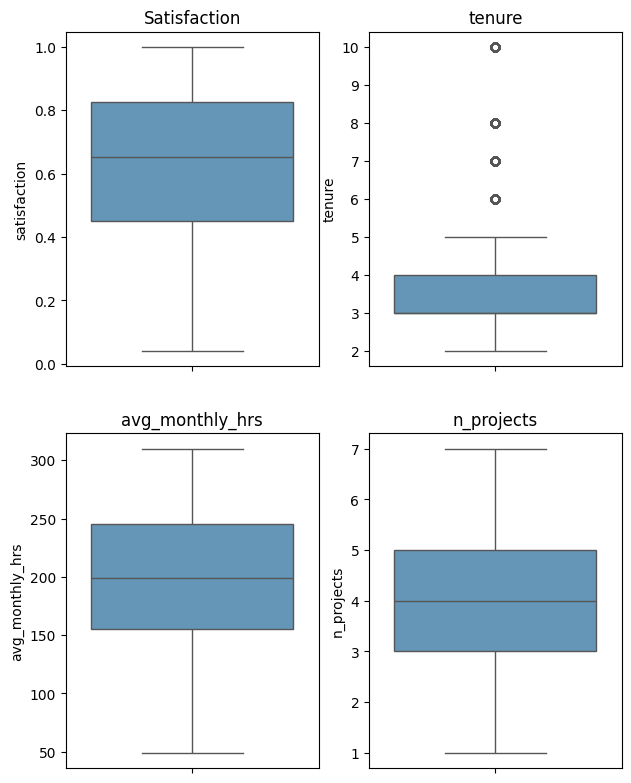

In [ ]:
plt.figure(figsize=(15,20))
plt.subplot2grid((4,4),(0,0))
sns.boxplot(y = eda.satisfaction,color='#5799c6')
plt.title('Satisfaction')
plt.subplot2grid((4,4),(0,1))
sns.boxplot(y=eda.tenure,color='#5799c6')
plt.title('tenure')
plt.subplot2grid((4,4),(1,0))
sns.boxplot(y=eda.avg_monthly_hrs,color='#5799c6')
plt.title('avg_monthly_hrs')
plt.subplot2grid((4,4),(1,1))
sns.boxplot(y=eda.n_projects,color='#5799c6')
plt.title('n_projects')
#Satisfaction, avg_monthly_hrs, n_projects there is no outliner so we can fill by mean
#Cột tenure possible to fill mean here but need furthur spec

Text(0, 0.5, 'Percentage')

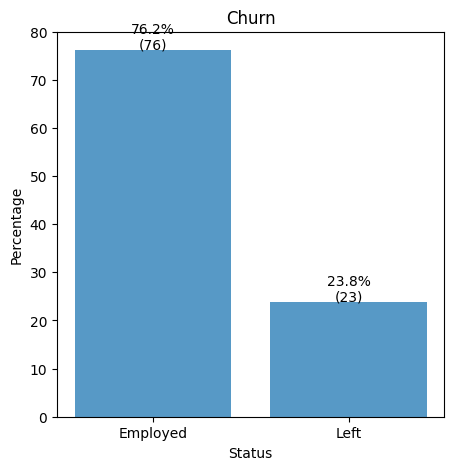

In [ ]:
plt.figure(figsize=(5,5))
churn_percentages = (eda['status'].value_counts() / len(eda)) * 100

plt.bar(churn_percentages.index, churn_percentages.values,color='#5799c6')
for i, v in enumerate(churn_percentages.values):
    plt.text(i, v+0.2, f"{v:.1f}%\n({int(v)})", ha='center')

plt.title('Churn')
plt.xlabel('Status')
plt.ylabel('Percentage')

Text(0.5, 0, 'Department')

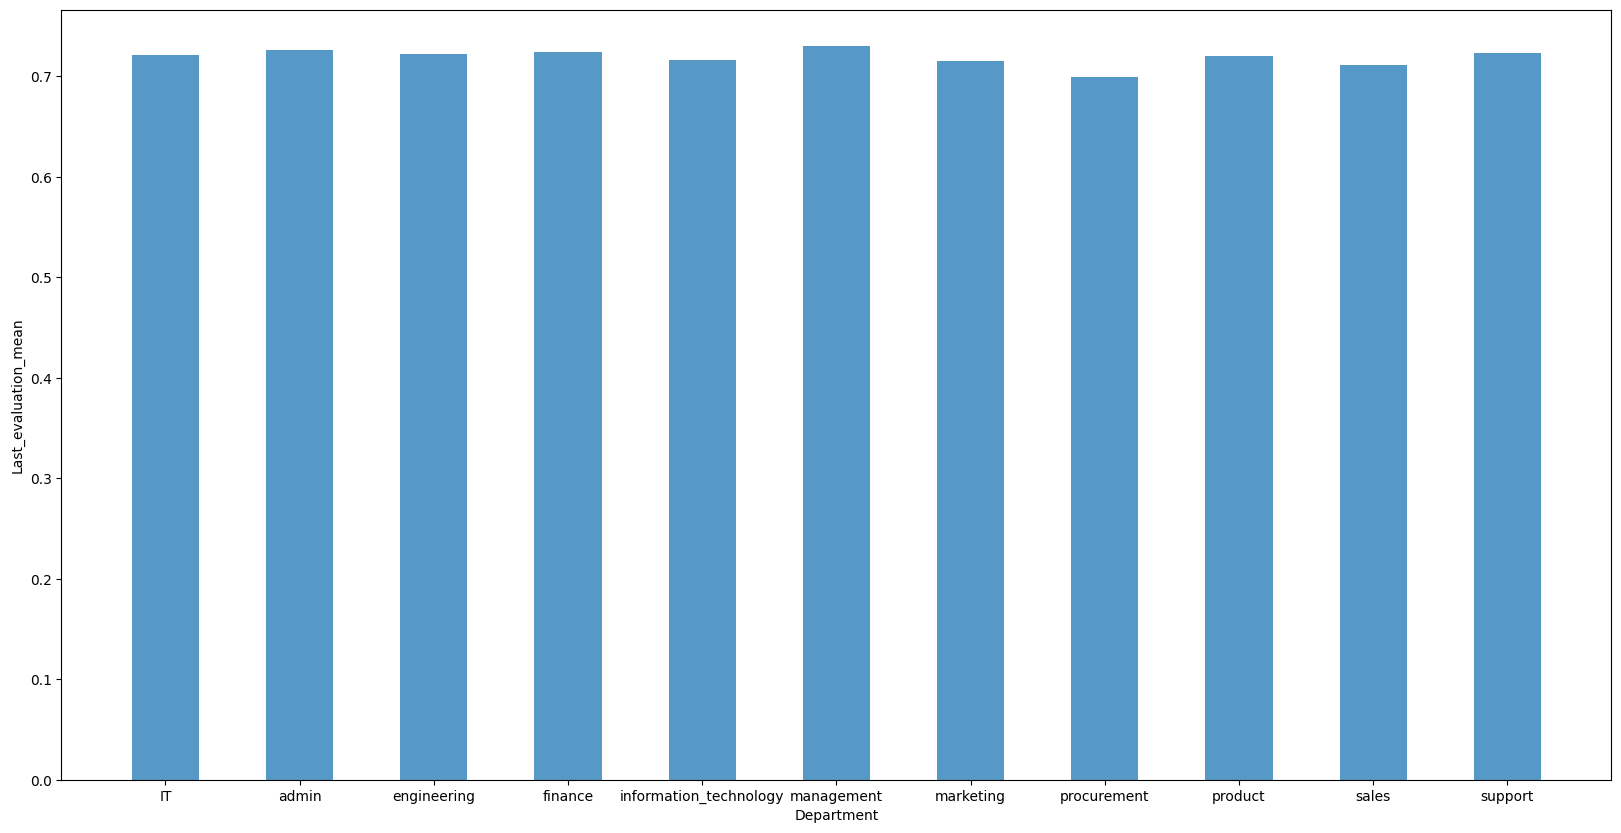

In [ ]:
mean_last_evaluation = eda.groupby('department')['last_evaluation'].mean()
plt.figure(figsize=(20, 10))
index = mean_last_evaluation.index

plt.bar(index, mean_last_evaluation.values, 0.5,color='#5799c6')
plt.ylabel('Last_evaluation_mean')
plt.xlabel('Department')
# => there are no different in each department we can fill mean

In [ ]:
eda.head(3)

,avg_monthly_hrs,department,filed_complaint,last_evaluation,n_projects,recently_promoted,salary,satisfaction,status,tenure
0,221,engineering,NaN,0.932868,4,NaN,low,0.829896,Left,5.0
1,232,support,NaN,NaN,3,NaN,low,0.834544,Employed,2.0
2,184,sales,NaN,0.788830,3,NaN,medium,0.834988,Employed,3.0


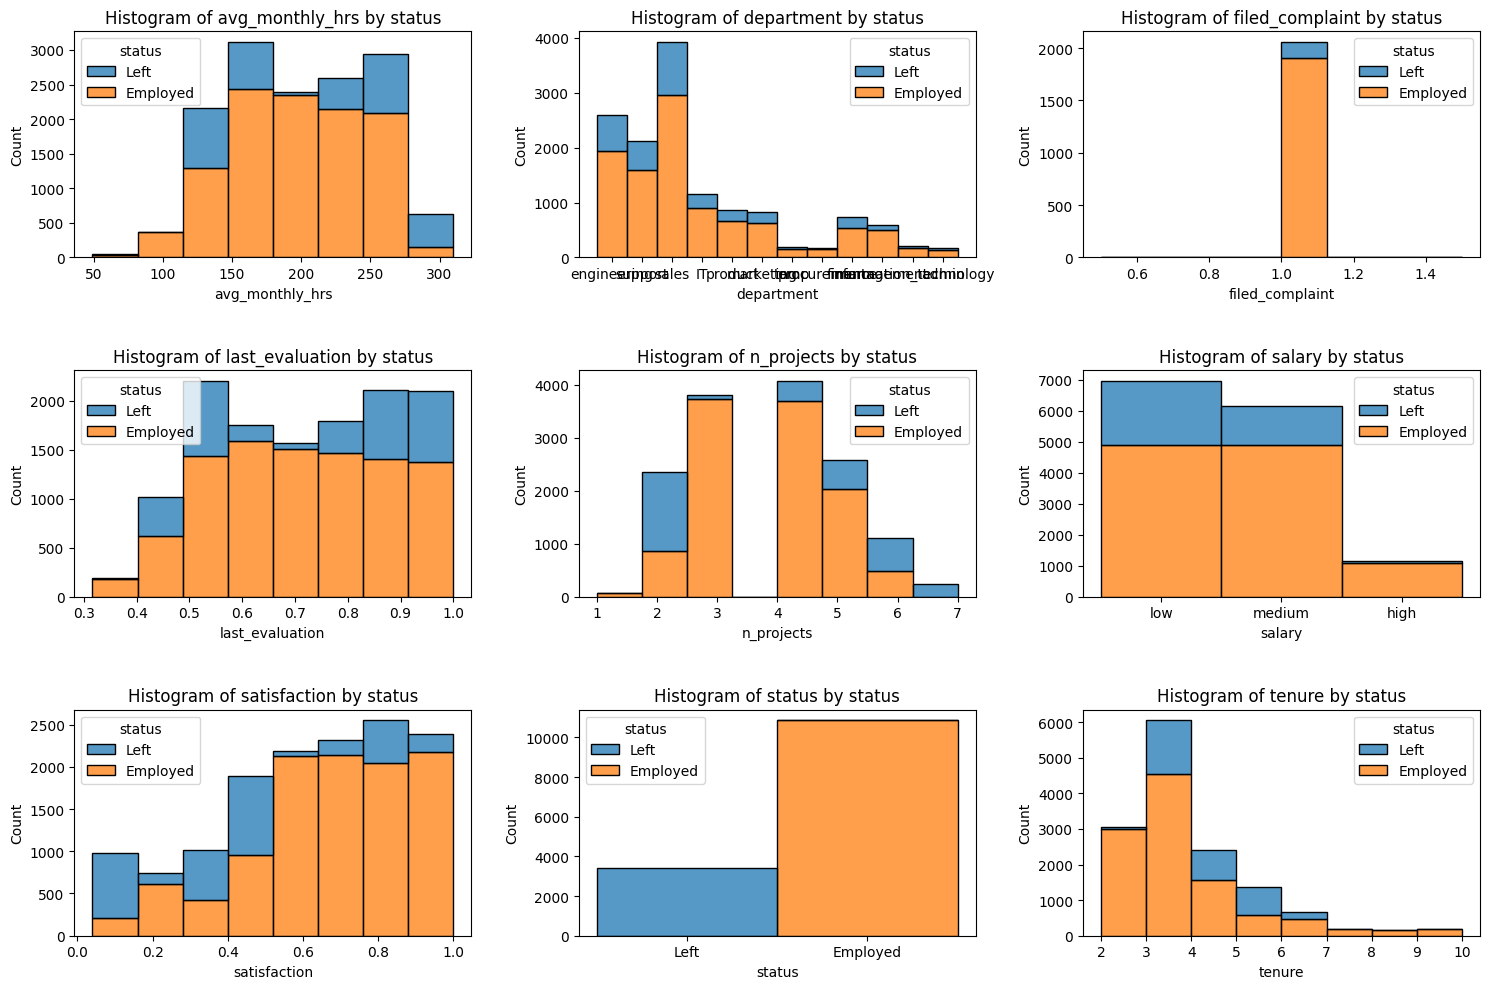

In [ ]:
# Graph subplot
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))

# Create a loop for each features
features = ['avg_monthly_hrs', 'department', 'filed_complaint', 'last_evaluation', 'n_projects', 'salary',
       'satisfaction', 'status', 'tenure']
for i, feature in enumerate(features):
    row, col = divmod(i, 3)
    sns.histplot(data=eda, x=feature, hue='status', multiple='stack', bins=8, ax=axs[row, col])
    axs[row, col].set_title(f'Histogram of {feature} by status')

# Change layout
plt.tight_layout()

# Điều chỉnh khoảng cách giữa chú thích và biểu đồ
plt.subplots_adjust(hspace=0.5)
plt.show()


# **Xử lý dữ liệu**

In [ ]:
cleaning=data_raw.copy()

In [ ]:
cleaning.drop_duplicates(inplace=True)

In [ ]:
#Fill mode department
cleaning['department'].fillna(cleaning['department'].mode()[0],inplace=True)

In [ ]:
#drop recently_promoted too many lost data => unable to recover
cleaning.drop('recently_promoted',axis=1,inplace=True)

In [ ]:
department_satisfaction_dict = cleaning.groupby('department')['satisfaction'].mean().to_dict()
department_satisfaction_dict

{'IT': 0.6283242200964685,
 'admin': 0.6114500250625,
 'engineering': 0.6179074420262346,
 'finance': 0.5867869613612637,
 'information_technology': 0.6267165012918661,
 'management': 0.6304275287361344,
 'marketing': 0.6291215213675214,
 'procurement': 0.6279296998218391,
 'product': 0.6287741562906977,
 'sales': 0.620210169578152,
 'support': 0.6269226474542884,
 'temp': nan}

In [ ]:
index_null_temp = cleaning["satisfaction"][cleaning["satisfaction"].isnull()].index

In [ ]:
#Satisfaction and Tenure are all null at department temp
cleaning.loc[index_null_temp, ['satisfaction', 'department','tenure','last_evaluation']].head(3)

,satisfaction,department,tenure,last_evaluation
24,NaN,temp,NaN,NaN
28,NaN,temp,NaN,NaN
44,NaN,temp,NaN,NaN


In [ ]:
#drop department temp because if we fill on mean there wouldnt make much sense
cleaning.drop(cleaning[cleaning['department'] == 'temp'].index,inplace = True)

In [ ]:
#Fill 0 for fill_complaint => There are no data possibly because they havent fill any form
values = {"filed_complaint": 0}
cleaning.fillna(value=values,inplace=True)

In [ ]:
cleaning.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14068 entries, 0 to 14248
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   avg_monthly_hrs  14068 non-null  int64  
 1   department       14068 non-null  object 
 2   filed_complaint  14068 non-null  float64
 3   last_evaluation  12717 non-null  float64
 4   n_projects       14068 non-null  int64  
 5   salary           14068 non-null  object 
 6   satisfaction     14068 non-null  float64
 7   status           14068 non-null  object 
 8   tenure           14068 non-null  float64
dtypes: float64(4), int64(2), object(3)
memory usage: 1.1+ MB


In [ ]:
index_null_last_evaluation = cleaning["last_evaluation"][cleaning["last_evaluation"].isnull()].index

In [ ]:
#cleaning['last_evaluation'].fillna(cleaning.groupby('department')['last_evaluation'].transform('mean'), inplace = True) code cũ group theo nhóm

cleaning['last_evaluation'].fillna(cleaning['last_evaluation'].mean(), inplace = True)

In [ ]:
cleaning.loc[index_null_last_evaluation, ['last_evaluation']].head(1)

,last_evaluation
1,0.718477


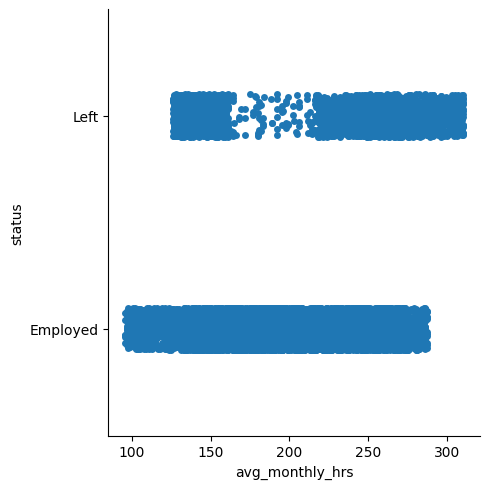

In [ ]:
sns.catplot(x="avg_monthly_hrs",y="status",data=cleaning)

In [ ]:
cleaning_left=cleaning[(cleaning.status=="Left")]

In [ ]:
cleaning_employed=cleaning[(cleaning.status=="Employed")]

<Axes: >

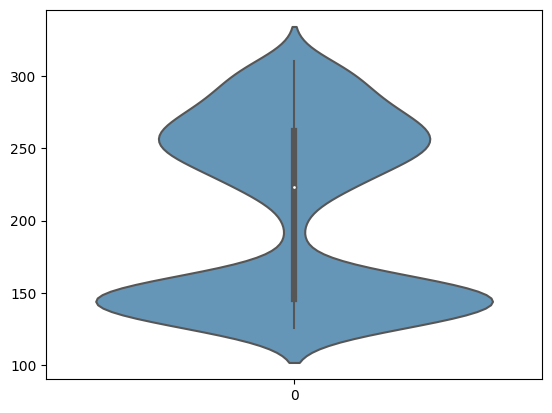

In [ ]:
sns.violinplot(cleaning_left["avg_monthly_hrs"],color='#5799c6')

<Axes: >

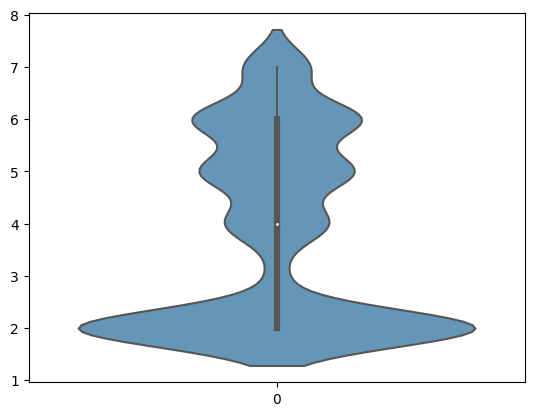

In [ ]:
sns.violinplot(cleaning_left["n_projects"],color='#5799c6')

# **Base model**

In [ ]:
model_data=cleaning.copy()

In [ ]:
model_data.head(3)

,avg_monthly_hrs,department,filed_complaint,last_evaluation,n_projects,salary,satisfaction,status,tenure
0,221,engineering,0.0,0.932868,4,low,0.829896,Left,5.0
1,232,support,0.0,0.718477,3,low,0.834544,Employed,2.0
2,184,sales,0.0,0.788830,3,medium,0.834988,Employed,3.0


In [ ]:
encode1 = OrdinalEncoder(categories=[['low', 'medium', 'high']])

In [ ]:
encoded_data = encode1.fit_transform(model_data[['salary']])

In [ ]:
model_data['salary'] = encoded_data

In [ ]:
encode1.categories_

[array(['low', 'medium', 'high'], dtype=object)]

In [ ]:
model_data['department'].nunique()
#Nếu có 11 unique data thì nên encode theo cách nào?

11

In [ ]:
#Tạm thời theo hướng Ordinal encoder sắp xếp theo thứ tự từ bé đến lớn theo số lần xuất hiện
department_count = model_data['department'].value_counts()
reversed_departments = department_count[::-1]
reversed_list = reversed_departments.index.tolist()
reversed_list

['procurement',
 'admin',
 'information_technology',
 'management',
 'finance',
 'marketing',
 'product',
 'IT',
 'support',
 'engineering',
 'sales']

In [ ]:
encode_2 = OrdinalEncoder(categories=[['procurement',
 'admin',
 'information_technology',
 'management',
 'finance',
 'marketing',
 'product',
 'IT',
 'support',
 'engineering',
 'sales']])

In [ ]:
encode_data_2 = encode_2.fit_transform(model_data[['department']])

In [ ]:
model_data['department'] = encode_data_2

Model loop

In [ ]:
models = [LogisticRegression(),
    DecisionTreeClassifier(max_depth=2),
    RandomForestClassifier(n_estimators=5),
    SVC(),
    KNeighborsClassifier(n_neighbors=2)]
precision=[]
recall=[]
f1=[]
time=[]
name=[]

In [ ]:
x = model_data.drop(columns=['status'])
y = model_data['status']
x_train , x_valid, y_train , y_valid = train_test_split(x , y , test_size = 0.2, random_state = 1)

In [ ]:
for model in models:
  t1 = datetime.datetime.now()
  model_name = model.__class__.__name__
  model.fit(x_train, y_train)
  t2= datetime.datetime.now()
  d = round((t2-t1).microseconds/1000,1)
  y_pred = model.predict(x_valid)
  pre = round(precision_score(y_valid, y_pred,pos_label='Left'),2)
  rec = round(recall_score(y_valid, y_pred,pos_label='Left'),2)
  f1_=round(f1_score(y_valid, y_pred,pos_label='Left'),2)
  precision.append(pre)
  recall.append(rec)
  f1.append(f1_)
  time.append(d)
  name.append(model_name)

In [ ]:
Results = pd.DataFrame(np.column_stack([name, precision, recall,f1,time]),columns=['Name', 'Precision','Recall','F1-score','Time (s)'])
Results
#=> random forest classifier

,Name,Precision,Recall,F1-score,Time (s)
0,LogisticRegression,0.65,0.37,0.47,310.7
1,DecisionTreeClassifier,0.85,0.4,0.54,45.7
2,RandomForestClassifier,0.97,0.92,0.94,152.8
3,SVC,1.0,0.1,0.19,77.8
4,KNeighborsClassifier,0.92,0.87,0.89,24.8


# **Improve model**

In [ ]:
#set threshold value thấp hơn

In [ ]:
model = RandomForestClassifier(n_estimators=10)
model.fit (x_train , y_train)

y_pred = model.predict(x_valid)
y_pred_prob = model.predict_proba(x_valid)

In [ ]:
result = []
for i in range(len(y_pred_prob)):
  if (y_pred_prob[i,1] < 0.4):
    result.append("Employed")
  else:
    result.append("Left")
result
result_forest = np.array(result)
print(classification_report(result, y_valid))

              precision    recall  f1-score   support

    Employed       0.99      0.98      0.98      2133
        Left       0.93      0.96      0.94       681

    accuracy                           0.97      2814
   macro avg       0.96      0.97      0.96      2814
weighted avg       0.97      0.97      0.97      2814



In [ ]:
#encode status to draw correlation
model_data_full_encode = model_data.copy()
encode_3 = OrdinalEncoder(categories=[['Employed', 'Left']])
encoded_data_3 = encode_3.fit_transform(model_data[['status']])
model_data_full_encode['status'] = encoded_data_3
encode_3.categories_

[array(['Employed', 'Left'], dtype=object)]

<Axes: >

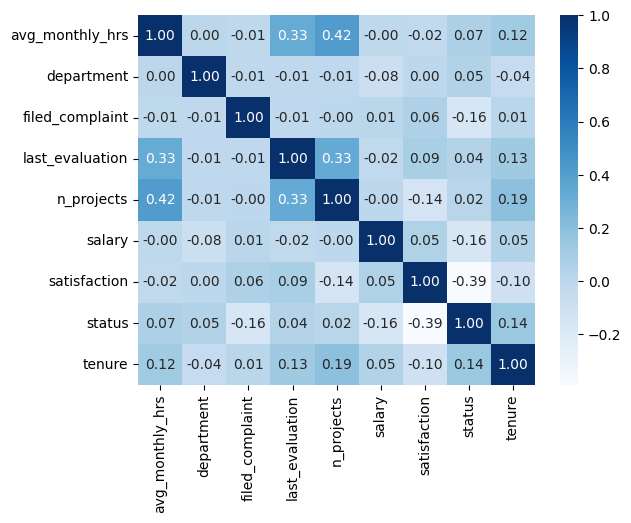

In [ ]:
sns.heatmap(model_data_full_encode.corr(), annot=True, cmap='Blues', fmt='.2f')
#Correlation are high with filed_complaint , salary , satisfaction , tenure => Use this 4 data train random forest

In [ ]:
x_improve = model_data[['filed_complaint','salary','satisfaction','tenure','department']]
y_improve = model_data['status']
x_train_improve , x_valid_improve , y_train_improve , y_valid_improve = train_test_split(x_improve , y_improve , test_size = 0.2, random_state = 1)


In [ ]:
model_forest_improve = RandomForestClassifier(n_estimators=10)
model_forest_improve.fit (x_train_improve , y_train_improve)

y_pred_improve = model_forest_improve.predict(x_valid_improve)
y_pred_prob_improve = model_forest_improve.predict_proba(x_valid_improve)

In [ ]:
result_improve = []
for i in range(len(y_pred_prob_improve)):
  if (y_pred_prob_improve[i,1] < 0.4):
    result_improve.append("Employed")
  else:
    result_improve.append("Left")
result_improve
result_forest_improve = np.array(result_improve)
print(classification_report(result_improve, y_valid_improve))

# There are no much improvement 
# => We can use this improvement data because we are using less data with the same result
# => Increase in proficiency 
# recall ở base model khá cao cho nên không cân bằng data lại (đã thử cân bằng data và nó làm hiệu quả model tệ hơn :v :v :v )

              precision    recall  f1-score   support

    Employed       0.92      0.94      0.93      2047
        Left       0.84      0.77      0.80       767

    accuracy                           0.90      2814
   macro avg       0.88      0.86      0.87      2814
weighted avg       0.90      0.90      0.90      2814



In [ ]:
Results["Precision"] = Results["Precision"].astype('float')
Results["Recall"] = Results["Recall"].astype('float')
Results["F1-score"] = Results["F1-score"].astype('float')

In [ ]:
Results=Results.sort_values(by=['Recall','Precision'],ascending=False)

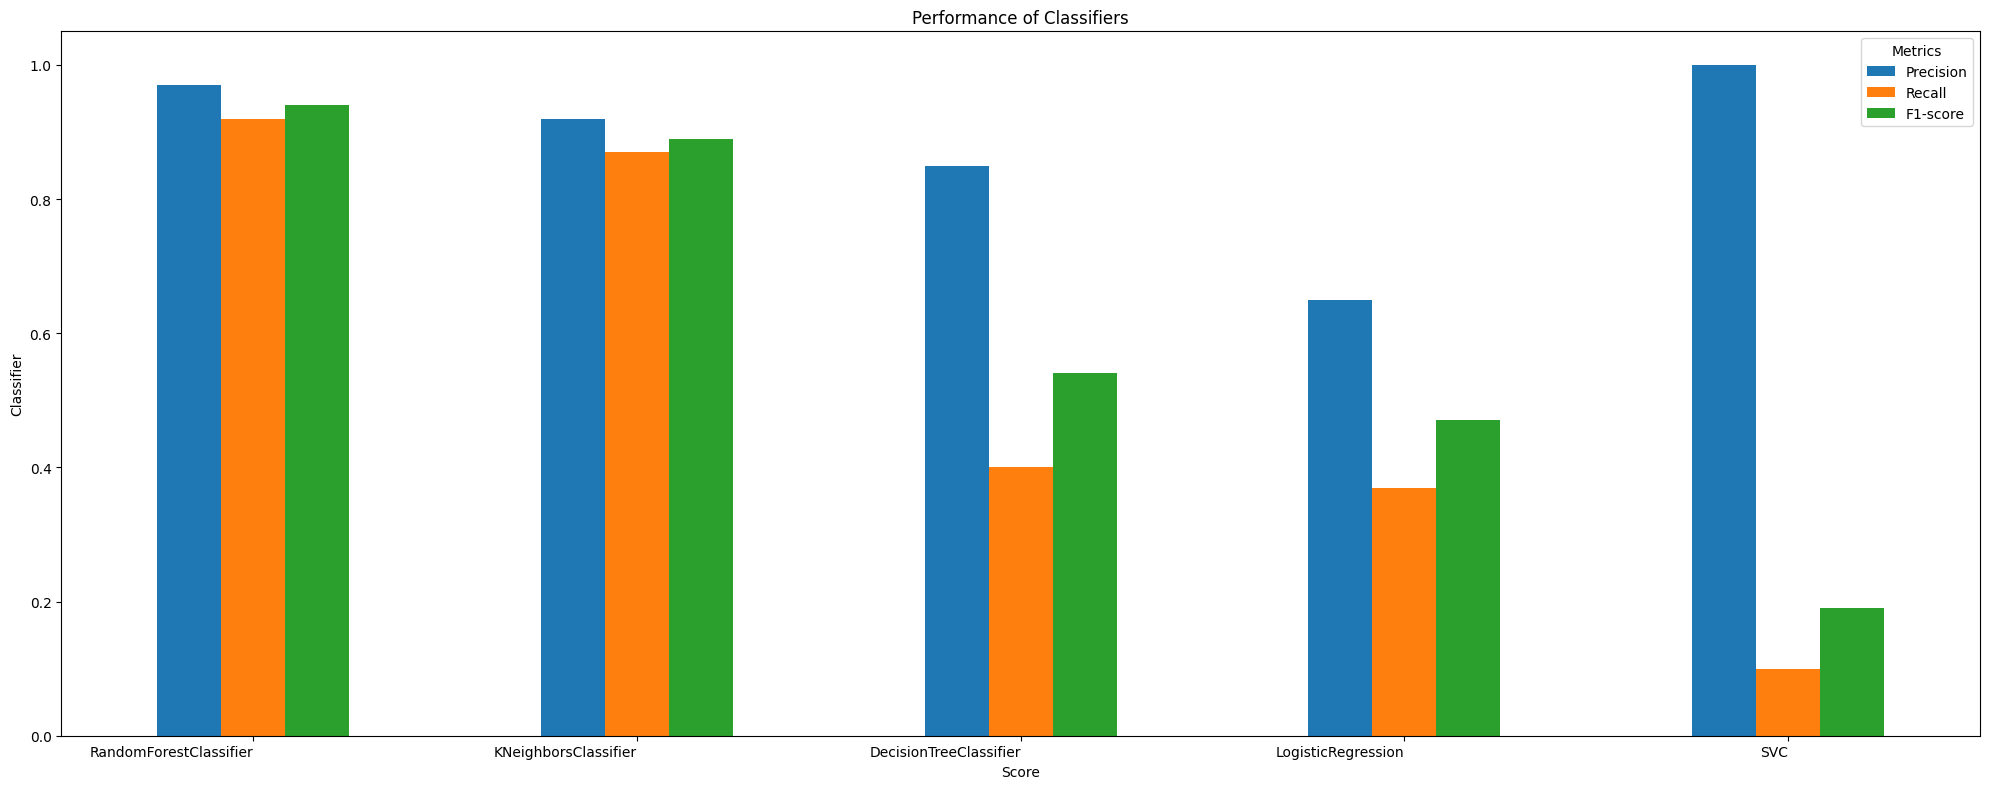

In [ ]:
Results.plot.bar(
    x="Name",
    stacked=False,
    title="Performance of Classifiers",
    figsize=(20, 8))

plt.xlabel("Score")
plt.xticks(rotation=0, ha="right")
plt.tight_layout()
plt.ylabel("Classifier")
plt.legend(title="Metrics")
plt.tight_layout()

In [ ]:
Results = Results.append({'Name':'Threshold = 0.4','Precision':'0.96','Recall':'0.97','F1-score':'0.96','Time (s)':'164.5'}, ignore_index=True)
Results = Results.append({'Name':'RF+','Precision':'0.89','Recall':'0.85','F1-score':'0.87','Time (s)':'164.5'}, ignore_index=True)

<ipython-input-57-1b4df117ab16>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Results = Results.append({'Name':'Threshold = 0.4','Precision':'0.96','Recall':'0.97','F1-score':'0.96','Time (s)':'164.5'}, ignore_index=True)
<ipython-input-57-1b4df117ab16>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Results = Results.append({'Name':'RF+','Precision':'0.89','Recall':'0.85','F1-score':'0.87','Time (s)':'164.5'}, ignore_index=True)


In [ ]:
Results["Precision"] = Results["Precision"].astype('float')
Results["Recall"] = Results["Recall"].astype('float')
Results["F1-score"] = Results["F1-score"].astype('float')
Results=Results.sort_values(by=['Recall','Precision'],ascending=False)

In [ ]:
Results.drop([2,3,4],axis=0,inplace=True)

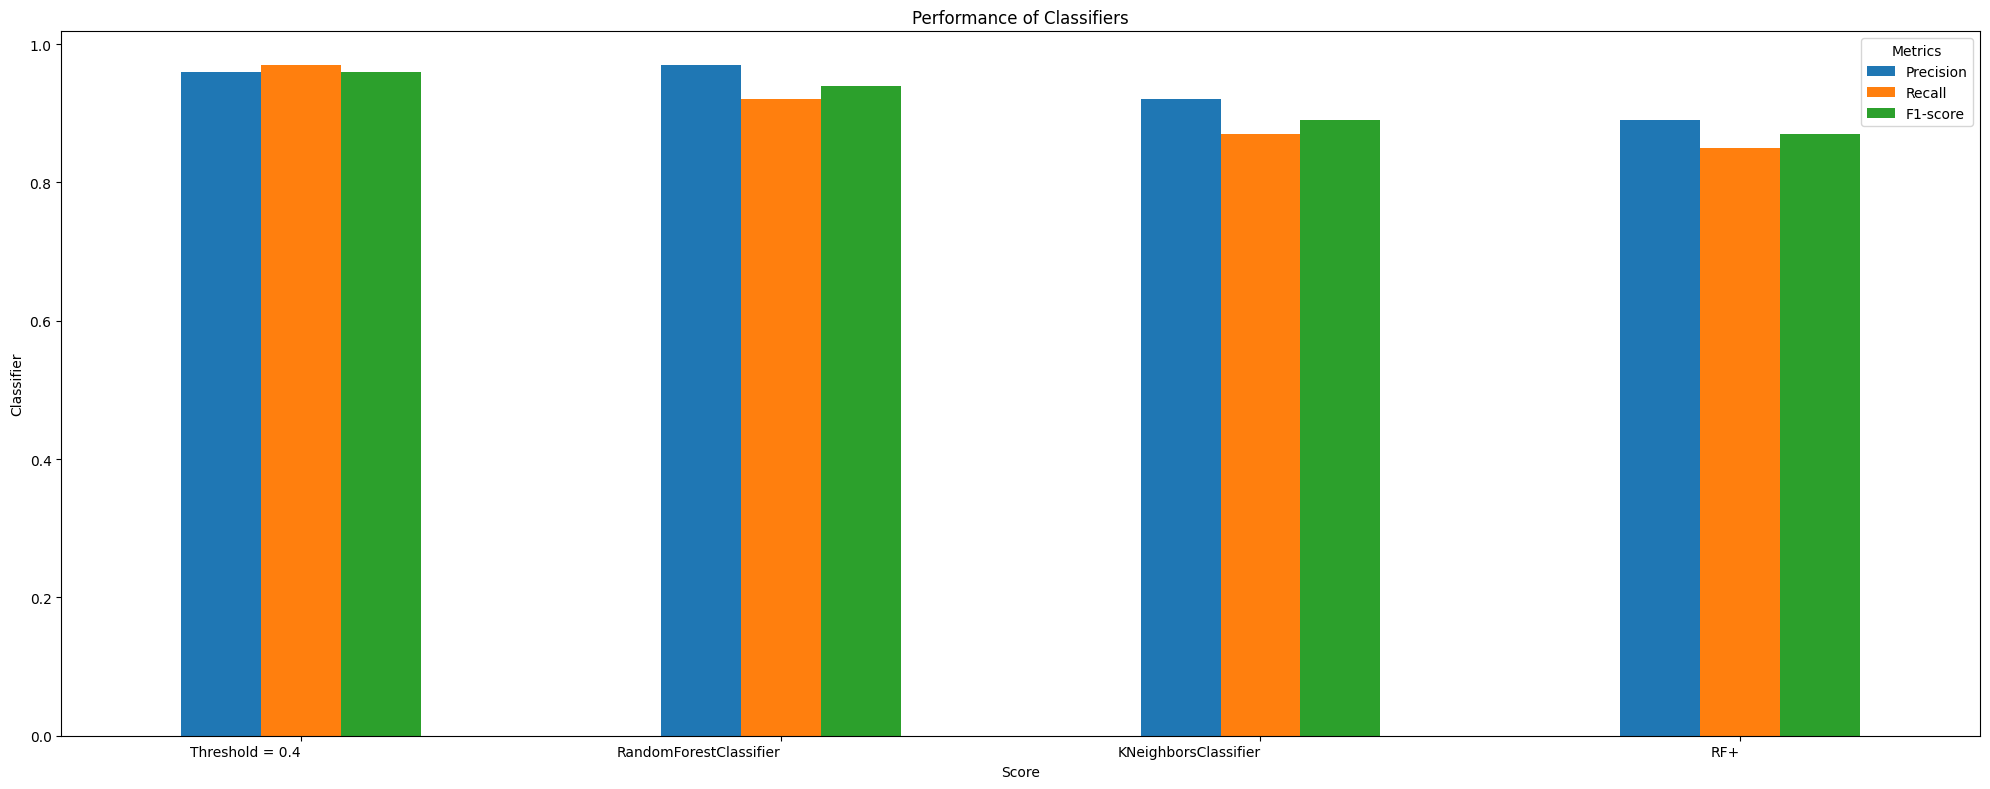

In [ ]:
Results.plot.bar(
    x="Name",
    stacked=False,
    title="Performance of Classifiers",
    figsize=(20, 8))

plt.xlabel("Score")
plt.xticks(rotation=0, ha="right")
plt.tight_layout()
plt.ylabel("Classifier")
plt.legend(title="Metrics")
plt.tight_layout()